# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Ensambles</center>
### <center> Práctica Boosting: Adaboost, Gradient Boosting, XGBoost</center>



En esta Notebook vamos a trabajar con el dataset Titanic para intentar clasificar si un pasajero sobrevivió o no mediante modelos de ensambles de tipo Boosting : **AdaBoost, Gradient Boosting, XGBoost**

## Boosting

Los algoritmos de boosting son uno de los algoritmos más populares y utilizados. Se pueden considerar como una de las técnicas más poderosas para construir modelos predictivos.

La idea es combinar varios "weak learners" (alto sesgo, baja varianza) en uno más fuerte, se entrenan los predictores secuencialmente y el modelo subsiguiente intenta corregir los errores de su predecesor.

Un weak learner típico es un árbol de profundidad 1 (stump) o árboles con muy poca profundidad.

Los ensambles son técnicas que crean múltiples modelos y luego los combinan para producir mejores resultados. Generalmente producen soluciones más precisas que las que produciría un solo modelo.

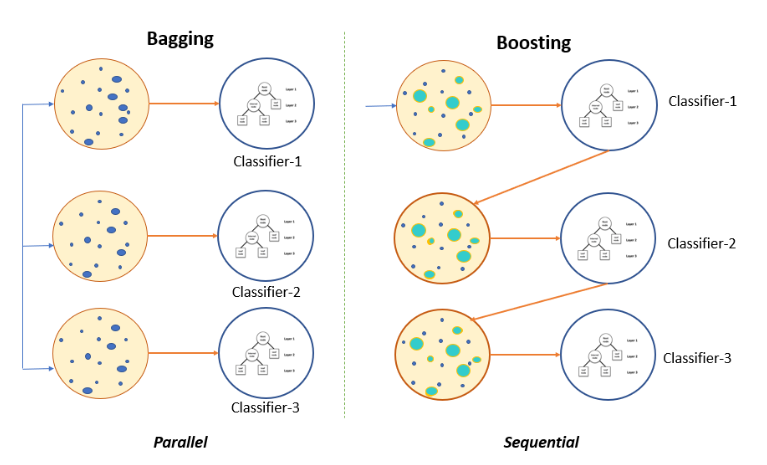

## Documentación

Ensambles

* https://scikit-learn.org/stable/modules/ensemble

AdaBoost

*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor


Gradient Boosting

*  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier
*  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor

XGBoost

* https://xgboost.readthedocs.io/en/stable/

## Clasificación

Vamos a trabajar con el dataset TITANIC

Descripción de los campos:

* PassengerId: Identificador del pasajero dentro de la tabla
* Survived: Indica si el pasajero sobrevivió
* Pclass: clase de pasajero primera(1), segunda (2) o tercera (3)
* Name: Nombre del pasajero
* Sex: Sexo del pasajero
* Age: Edad
* SibSp: Cantidad de hermanas/os o esposas/os a bordo
* Parch: Cantidad de padres o hijos a bordo
* Ticket: Número de ticket
* Fare: Tarifa
* Cabin: Cabina en la cual se encuentra alojado el pasajero
* Embarked: Puerta de embarque

### Librerias y Dataset

In [ ]:
import pandas as pd
import numpy as np

import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt
from six import StringIO
import pydotplus
from IPython.display import Image  

from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('always')

In [ ]:
dataset=pd.read_csv('./datasets/ds_titanic.csv')

### Preprocesamiento de Datos

In [ ]:
dataset.drop(['PassengerId','Name',"Ticket","Cabin"], axis='columns', inplace=True)
dataset=pd.get_dummies(dataset,columns=["Pclass","Sex","Embarked"],drop_first=True)
dataset.dropna(inplace=True)
dataset

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
885,0,39.0,0,5,29.1250,0,1,0,1,0
886,0,27.0,0,0,13.0000,1,0,1,0,1
887,1,19.0,0,0,30.0000,0,0,0,0,1
889,1,26.0,0,0,30.0000,0,0,1,0,0


In [ ]:
dataset.rename(columns={'Survived':'Target'}, inplace=True)
dataset.Target.value_counts(normalize=True)

0    0.593838
1    0.406162
Name: Target, dtype: float64

In [ ]:
features=list(dataset.columns)
features.remove('Target')
print(features)

['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S']


In [ ]:
#Separo un set de Evaluacion
x_train, x_test, y_train, y_test = train_test_split(dataset[features].values, 
                                                    dataset['Target'].values, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=dataset['Target'].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 571
# Datos Prueba: 143
% Positivos Entrenamiento: 40.630
% Positivos Prueba: 40.559


### AdaBoost - Adaptive Boosting

AdaBoost combina muhcos "weak learners" para hacer clasificaciones. Se los denomina STUMPS (sólo un nodo y dos hojas) es decir que usan un único feature para decidir.

Cada STUMP tiene un peso en la clasificación final, este peso depende de cuan bien clasificó las muestras (es una funcion del error total del stump). El que mejor clasificó tendrá mas peso.

Los STUMP se construyen teniendo en cuenta los errores del STUMP anterior. Por esto el orden es importante : los errores que comete un clasificador influyen en la construccion del siguiente. 

La gran desventaja de este algoritmo es que no se puede paralelizar el modelo ya que cada predictor solo se puede entrenar después de haber entrenado y evaluado el anterior.


In [ ]:
#Construyo el modelo y lo entreno
from sklearn.ensemble import AdaBoostClassifier

ab_model = AdaBoostClassifier(n_estimators=10, random_state=0)
ab_model.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=10, random_state=0)

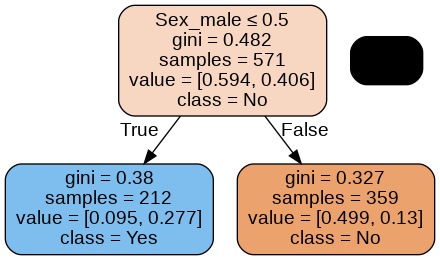

In [ ]:
# Grafico el primer STUMP
dot_data = StringIO()
export_graphviz(ab_model.estimators_[0], out_file=dot_data,   filled=True, rounded=True,
                special_characters=True,feature_names=features,class_names=['No','Yes'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

AUC: 0.8462474645030426


Text(33.0, 0.5, 'True')

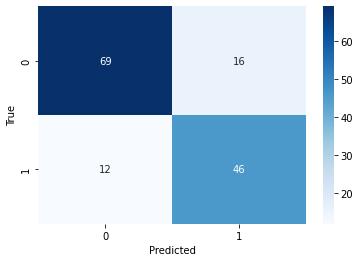

In [ ]:
#Evalúo en el set de test

#AUC
y_pred_proba= ab_model.predict_proba(x_test)[:, 1]
print ('AUC:', roc_auc_score(y_test, y_pred_proba))

#Matriz Confusión
y_pred=ab_model.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
#Reporte
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.85      0.81      0.83        85
           1       0.74      0.79      0.77        58

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.80      0.81       143



### Gradient Boosting

A diferencia de AdaBoost Gradient Boost comienza con una hoja en lugar de un stump.Luego construye arboles pero de más de un nivel y todos aportan lo mismo a la clasificación final. Se construyen tantos árboles como se solicite o hasta que los árboles adicionales no logren mejorar el ajuste.

Permite elegir una función de costo L , por ejemplo, error cuadrático medio si es un problema de regresión, o entropía cruzada si es un problema de clasificación, y cada árbol que construye lo hace de manera que la función de costo se minimice (técnica de optimización se denomina descenso por gradiente).

En cada iteración construimos un árbol nuevo que aprenda a predecir el residuo
entre las observaciones y los valores predichos por el árbol anterior. 




Parámetros específicos del árbol: afectan a cada árbol individual del modelo.

* Criterio de elección de atributos en cada nodo (Information Gain, Gini Gain)
* Criterio de parada (ej: máxima profundidad generalmente se usa 5 o 6)
* Estrategia de poda

Parámetros de boosting: estos afectan la operación de boosting en el modelo.

* **learning_rate** (por defecto=0.1): la tasa de aprendizaje reduce la contribución de cada árbol. Hay una compensación entre learning_rate y la cantidad de estimadores.

* **n_estimators** (por defecto=100): cantidad de estimadores que se van a utilizar.


In [ ]:
#Construyo el modelo y lo entreno
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=17)
gb_model.fit(x_train, y_train)


GradientBoostingClassifier(random_state=17)

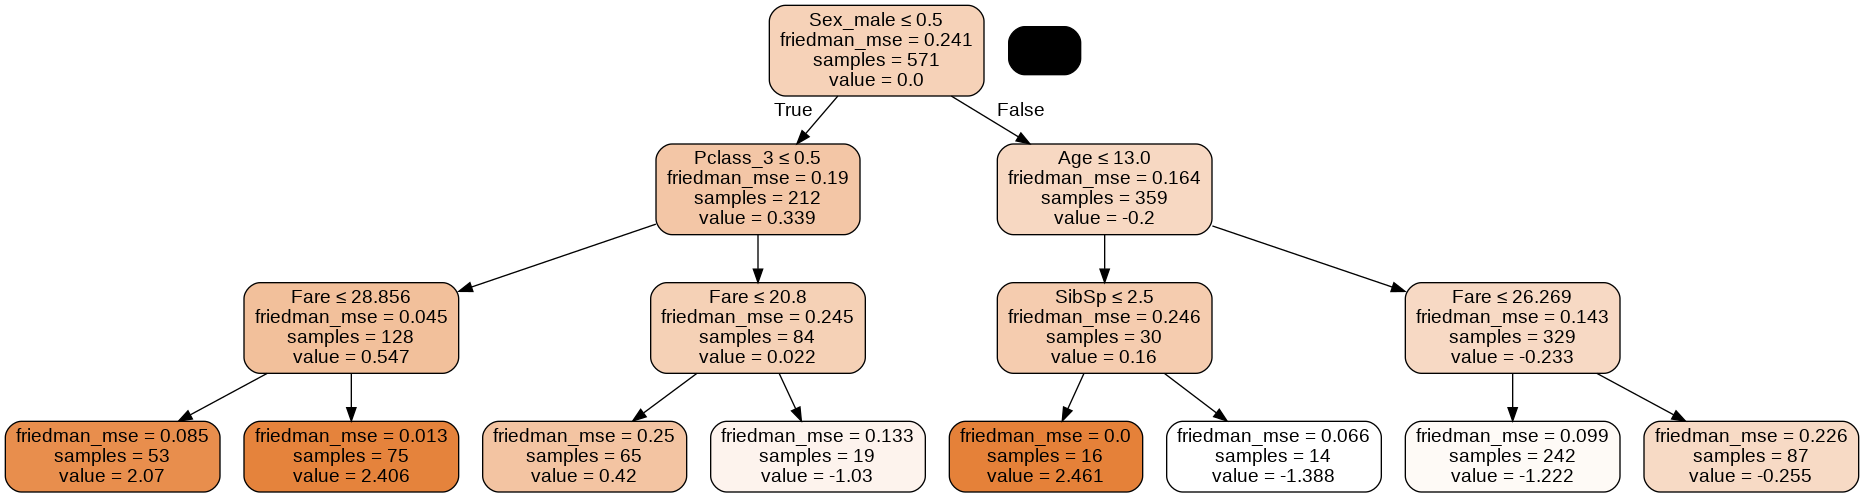

In [ ]:
#Grafico el primer árbol 
dot_data = StringIO()
export_graphviz(gb_model.estimators_[0][0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
#Evalúo en el set de test

#AUC
y_pred_proba= gb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusión
y_pred=gb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
#sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
#plt.xlabel('Predicted')
#plt.ylabel('True')

AUC: 0.8860040567951318


In [ ]:
#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        85
           1       0.82      0.72      0.77        58

    accuracy                           0.83       143
   macro avg       0.82      0.81      0.81       143
weighted avg       0.83      0.83      0.82       143



TODO: Optimización de hiperparámetros

Probar distintas combinaciones de parámetros para optimizar

In [ ]:
#Parámetros a optimizar
params_grid = {'n_estimators':range(20, 150, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.001)}

#Folds
kfoldcv = StratifiedKFold(n_splits=5)

#Ramdom Search CV
randomcv = RandomizedSearchCV(GradientBoostingClassifier(), params_grid, n_jobs=10, scoring='roc_auc',cv=kfoldcv, n_iter=10)
randomcv.fit(x_train,y_train)

print (randomcv.best_score_, randomcv.best_params_)

#Mejor Modelo
gb = randomcv.best_estimator_

0.8405058866574782 {'n_estimators': 35, 'max_depth': 2, 'learning_rate': 0.322}


In [ ]:
#Evalúo en el set de train
y_pred_proba= gb.predict_proba(x_train)[:, 1]
print('AUC:',roc_auc_score(y_train, y_pred_proba))


AUC: 0.9305640321432203


In [ ]:
#Evalúo en el set de test

#AUC
y_pred_proba= gb.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusión
y_pred=gb.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
#sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
#plt.xlabel('Predicted')
#plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

AUC: 0.8893509127789047
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        85
           1       0.84      0.66      0.74        58

    accuracy                           0.81       143
   macro avg       0.82      0.79      0.80       143
weighted avg       0.82      0.81      0.81       143



### XGBoost - Extreme Gradient Boosting

XGBoost es una forma más regularizada de Gradient Boosting . XGBoost utiliza la regularización avanzada (L1 y L2), que mejora las capacidades de generalización del modelo.

XGBoost ofrece un alto rendimiento en comparación con Gradient Boosting. Su entrenamiento es muy rápido y se puede paralelizar entre clústeres.

**Hiper-parámetros**

* learning_rate: tasa de aprendizaje
+ max_depth: máxima profundidad de cada árbol
* subsample: porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* n_estimators: cantidad de árboles a construir.
* objective: función de error a utilizar (algunas: reg:linear para regresión,
* reg:logistic o binary:logistic para clasificación)

**Parámetros de regularización:**

* **gamma**: umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha**: regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda**: similar alpha pero para la sintonia fina.

In [ ]:
#Creo el modelo y lo entreno

import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

XGBClassifier()

AUC: 0.8862068965517242
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        85
           1       0.80      0.69      0.74        58

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



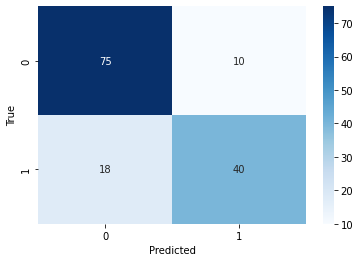

In [ ]:
#Evaluo en el set de test
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))


Con el método CV puedo entrenar el modelo y ver como impacta la modificacion de algun parámetro.

* nfolds: K del k-fold son 3 por defecto.
* num_boost_round: cantidad de árboles a contruir (n_estimators)
* metrics: la métrica de evaluación a utilizar
* as_pandas: si los resultados lo devuelve en un DataFrame de pandas
* early_stopping_rounds: terminar antes si la métrica no mejora luego de una cantidad de iteraciones (por defecto 9)
* seed: semilla para poder reproducir los resultados

In [ ]:
#Datos de entrenamiento en formaro DMatrix
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

#Entreno CV para probar el learning rate
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.1},num_boost_round=8,metrics='auc')
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.929096,0.004940,0.829758,0.029552
1,0.936649,0.009003,0.828234,0.023415
2,0.942148,0.006025,0.825818,0.024350
3,0.944772,0.008438,0.823214,0.025815
4,0.948508,0.007344,0.821948,0.027259
5,0.950187,0.006613,0.820528,0.027324
6,0.956523,0.003907,0.825506,0.029773
7,0.958262,0.002903,0.824638,0.029848


In [ ]:
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.2},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.929096,0.004940,0.829758,0.029552
1,0.941714,0.005537,0.825587,0.024834
2,0.950523,0.005258,0.823802,0.022124
3,0.957022,0.005177,0.821862,0.021254
4,0.960485,0.005238,0.825544,0.029268
5,0.962392,0.005032,0.824392,0.032098
6,0.967813,0.002392,0.831711,0.036624
7,0.969797,0.001758,0.831893,0.035789


TO DO: Comparar los resultados de los tres modelos.

## Regresión

Problema de Regresión: predecir valores continuos como la edad, el peso o el precio

Vamos a usar como métrica el Error Cuadtrático Medio (MSE)

TO DO: Guía de Ejercicios

TO DO: Optimizar un hiperparámetro de regularización

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.keys())
print(boston.feature_names)
print(boston.DESCR)

In [ ]:
# EJEMPLO

#xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

#xgbr = xgb.XGBRegressor()
#xgbr.fit(xtrain, ytrain)
 
#ypred = xgbr.predict(xtest)

#mse = mean_squared_error(ytest, ypred)
#print("RMSE: %.2f" % (mse**(1/2.0)))